In [23]:
# SVM WITH MERGED DATA

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay, classification_report
from sklearn.model_selection import KFold, GridSearchCV
from sklearn.linear_model import LogisticRegression
%matplotlib inline

df = pd.read_csv('merged_data_NEWer.csv', sep=',', header=0)
df = df.drop('timestamp', axis=1)
df = df.drop('date', axis=1)
df.shape
# we have 2 discrete variables and 12 continuous variables
df.head()

,sequence_name,activity,chest_x-coordinate,chest_y-coordinate,chest_z-coordinate,belt_x-coordinate,belt_y-coordinate,belt_z-coordinate,ar_x-coordinate,ar_y-coordinate,ar_z-coordinate,al_x-coordinate,al_y-coordinate,al_z-coordinate
0,A01,walking,4.291954,1.781140,1.344495,4.359101,1.826456,0.968821,4.324462,2.07246,0.488065,4.062931,1.892434,0.507425
1,A01,walking,4.291954,1.781140,1.344495,4.359101,1.826456,0.968821,4.324462,2.07246,0.488065,4.071232,1.888289,0.493945
2,A01,walking,4.309984,1.777778,1.333371,4.359101,1.826456,0.968821,4.324462,2.07246,0.488065,4.079534,1.884144,0.480464
3,A01,walking,4.328015,1.774416,1.322246,4.362803,1.841832,0.918870,4.324462,2.07246,0.488065,4.087835,1.879999,0.466983
4,A01,walking,4.346046,1.771054,1.311121,4.366505,1.857208,0.868920,4.324462,2.07246,0.488065,4.055501,1.835890,0.477998


In [3]:
# check distribution of 'activity' column
# the counts describe how long the person was performing the activity for and helps 
# describe the data. It's not necessarilly a data imbalance
df['activity'].value_counts()

lying                                     54480
walking                                   32710
sitting                                   27244
standing up from lying                    18361
sitting on the ground                     11779
lying down                                 6168
on all fours                               5210
falling                                    2973
standing up from sitting on the ground     2848
sitting down                               1706
standing up from sitting                   1381
Name: activity, dtype: int64

In [4]:
# view the percentage distribution of 'activity' column
df['activity'].value_counts()/len(df)

lying                                     0.330462
walking                                   0.198411
sitting                                   0.165255
standing up from lying                    0.111373
sitting on the ground                     0.071449
lying down                                0.037414
on all fours                              0.031603
falling                                   0.018033
standing up from sitting on the ground    0.017275
sitting down                              0.010348
standing up from sitting                  0.008377
Name: activity, dtype: float64

In [5]:
# check for null values in data set
df.isnull().sum()

sequence_name         0
activity              0
chest_x-coordinate    0
chest_y-coordinate    0
chest_z-coordinate    0
belt_x-coordinate     0
belt_y-coordinate     0
belt_z-coordinate     0
ar_x-coordinate       0
ar_y-coordinate       0
ar_z-coordinate       0
al_x-coordinate       0
al_y-coordinate       0
al_z-coordinate       0
dtype: int64

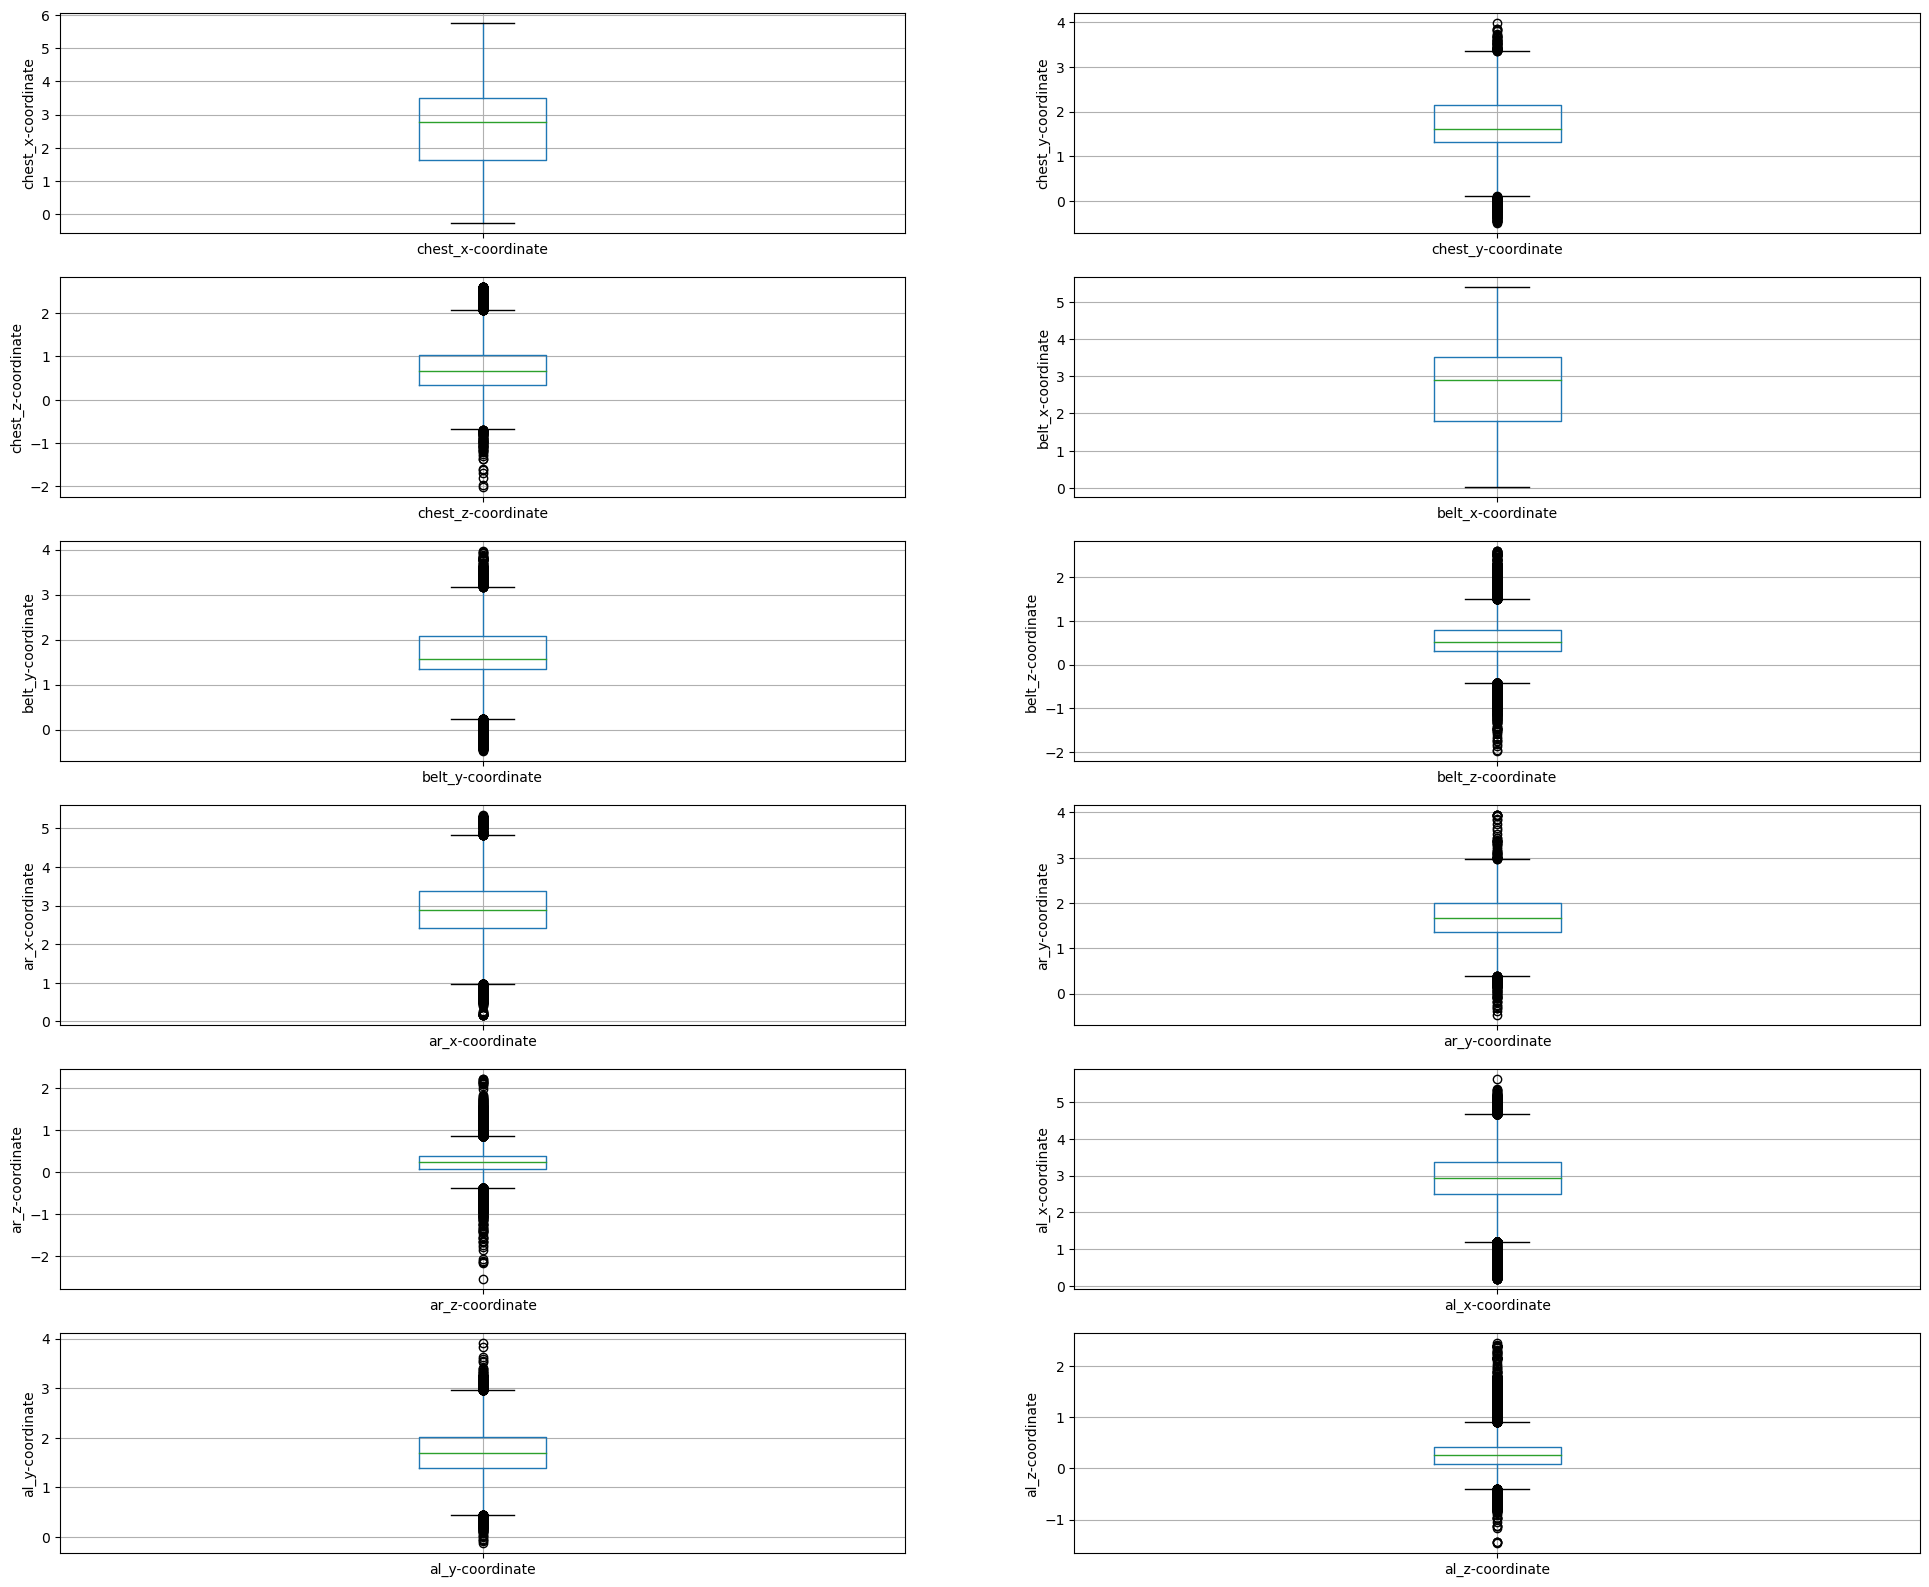

In [6]:
plt.figure(figsize=(24,20))

# box plots show lots of outliers
# but why are no data points showing up on some of the x coord box plots?
for i, column in enumerate(df):
    if (column != 'sequence_name') and (column != 'activity'):
        i -= 2
        plt.subplot(6, 2, 1+i)
        fig = df.boxplot(column=column)
        fig.set_title('')
        fig.set_ylabel(column)

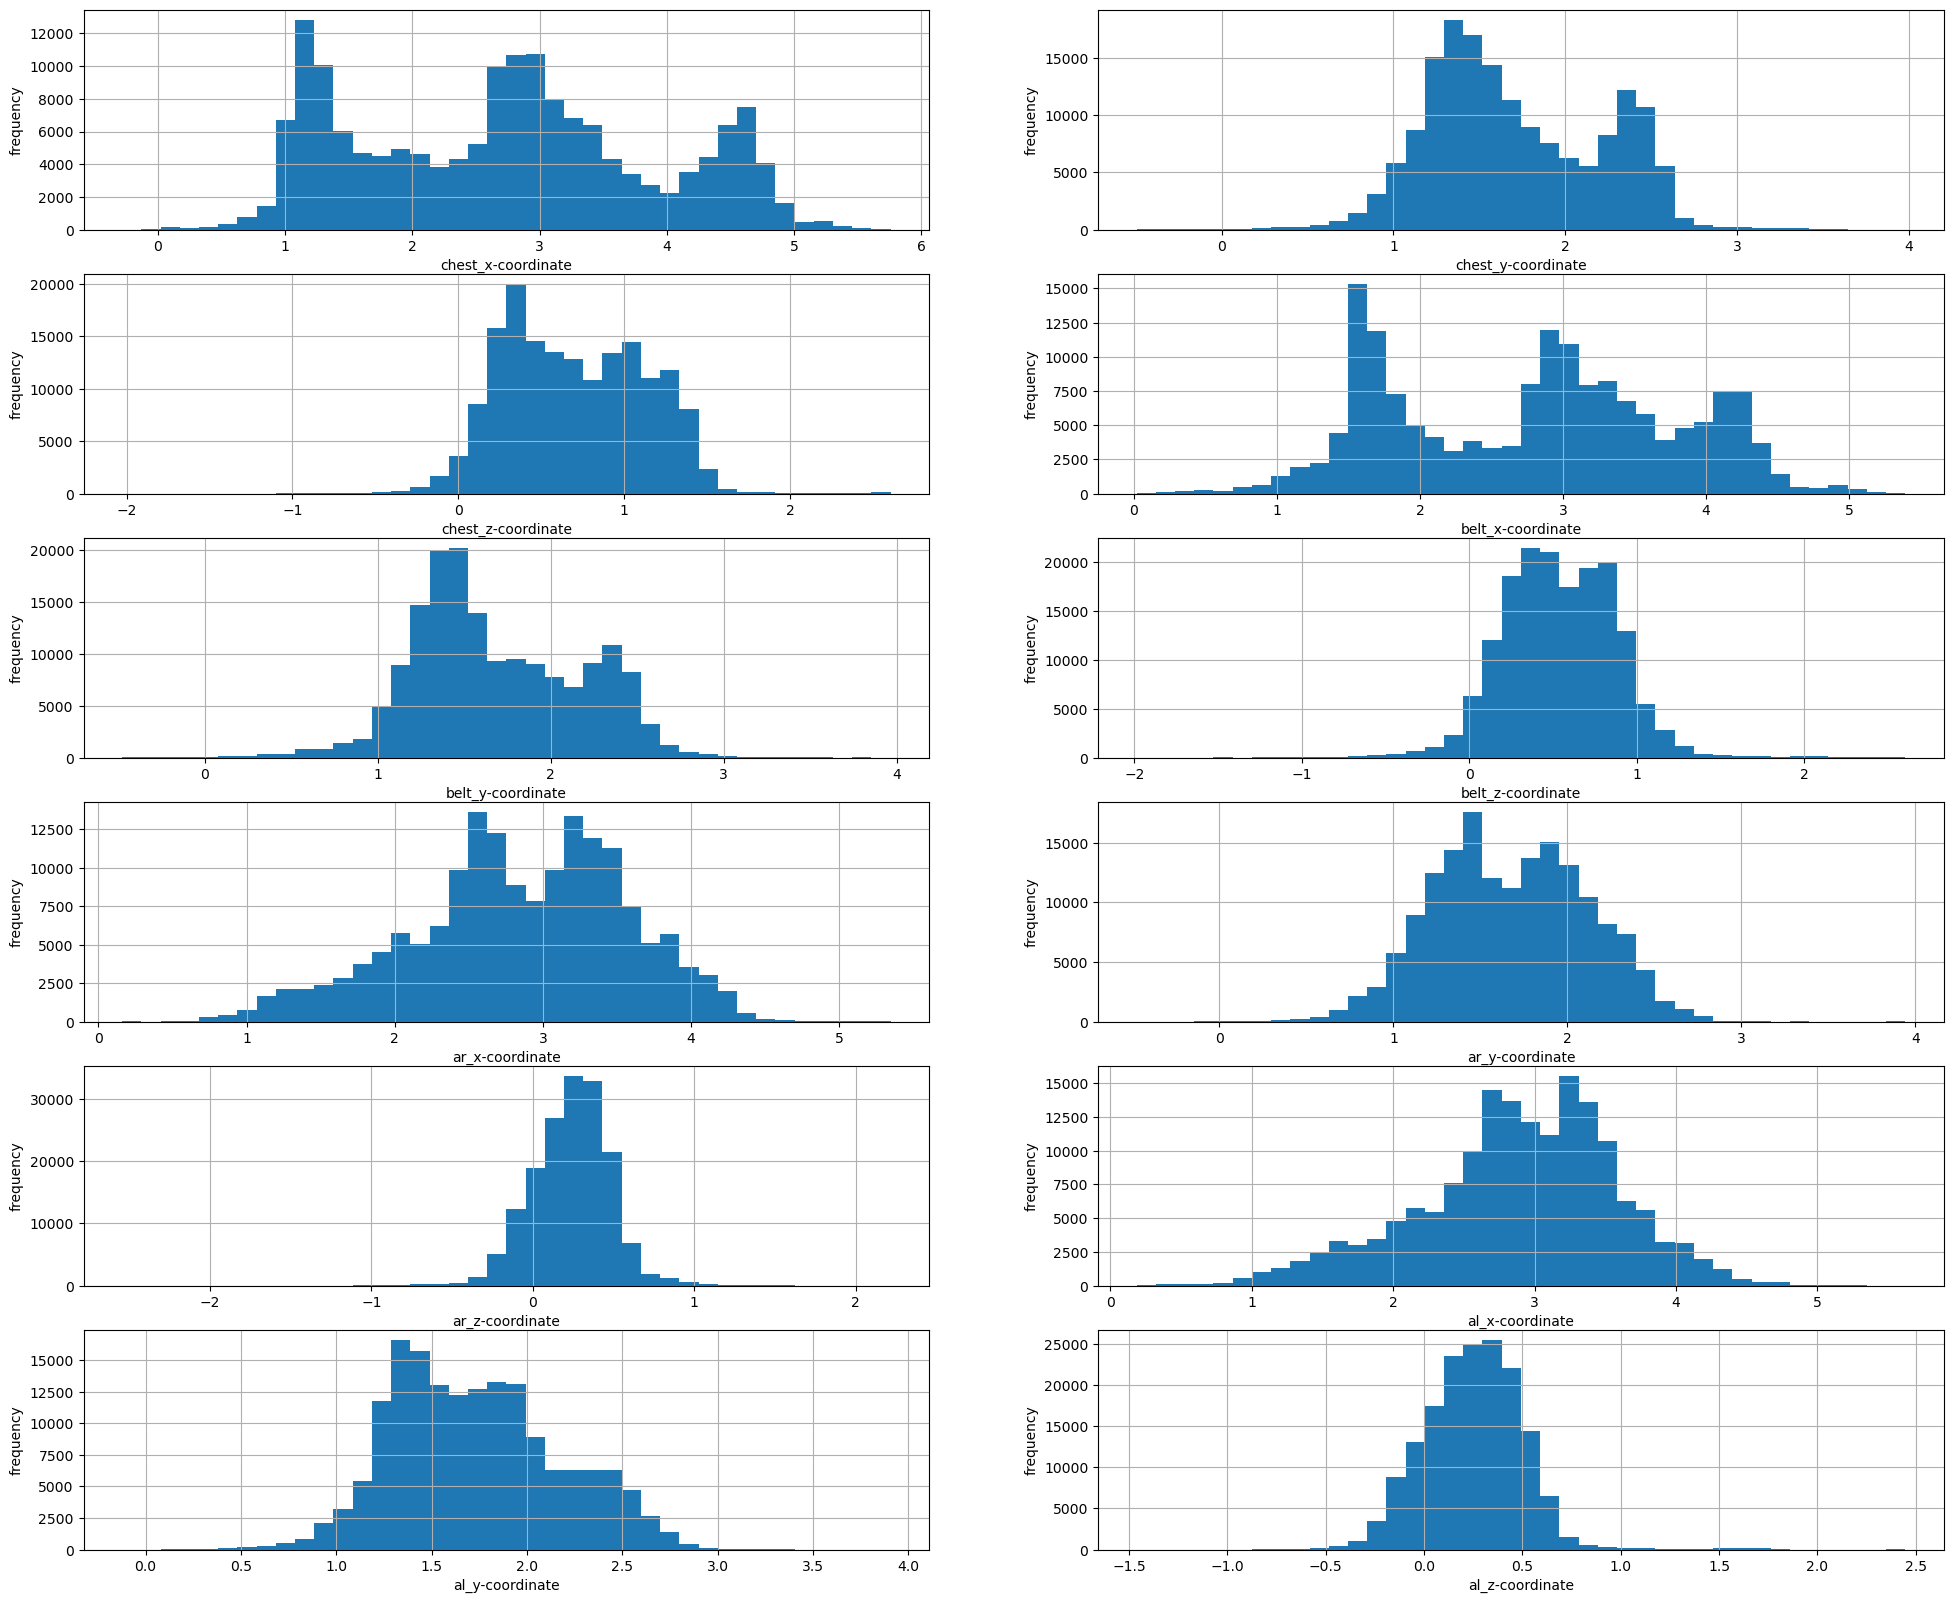

In [7]:
plt.figure(figsize=(24,20))

# distributions look quite good overall. Not much skewing.
for i, column in enumerate(df):
    if (column != 'sequence_name') and (column != 'activity'):
        i -= 2
        plt.subplot(6, 2, 1+i)
        fig = df[column].hist(bins=40)
        fig.set_title('')
        fig.set_xlabel(column)
        fig.set_ylabel('frequency')

# Encoding, Scaling and Training

In [32]:
# here we: 
# manually establish a test and training data set
# encode the categorical data in preparation for scaling
le = LabelEncoder()
train_data = df
test_data = df

# Encode sequence_name and activity columns for testing and training data in 
# preparation for scaling and training (important for SVM)
test_data['sequence_name'] = le.fit_transform(df['sequence_name'])
test_data['activity'] = le.fit_transform(df['activity'])

train_data['sequence_name'] = le.fit_transform(df['sequence_name'])
train_data['activity'] = le.fit_transform(df['activity'])

# All A01-A05 sequences are selected (encoded 0-5). Roughly 20% of our data.
test_data = test_data[(test_data['sequence_name'] <= 4)]
train_data = train_data[(train_data['sequence_name'] >= 5)]

X_train = train_data.drop('sequence_name', axis = 1)
y_train = train_data['activity'] 

X_test = test_data.drop('sequence_name', axis = 1)
y_test = test_data['activity'] 

In [33]:
# feature scaling
cols = X_train.columns
scaler = StandardScaler()

X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)
X_train = pd.DataFrame(X_train, columns=[cols])
X_test = pd.DataFrame(X_test, columns=[cols])

X_train.describe()

,activity,chest_x-coordinate,chest_y-coordinate,chest_z-coordinate,belt_x-coordinate,belt_y-coordinate,belt_z-coordinate,ar_x-coordinate,ar_y-coordinate,ar_z-coordinate,al_x-coordinate,al_y-coordinate,al_z-coordinate
count,1.373870e+05,1.373870e+05,1.373870e+05,1.373870e+05,1.373870e+05,1.373870e+05,1.373870e+05,1.373870e+05,1.373870e+05,1.373870e+05,1.373870e+05,1.373870e+05,1.373870e+05
mean,6.578573e-17,2.019084e-16,-8.399058e-17,-2.887952e-16,1.630162e-16,1.290890e-16,1.530863e-16,-2.383181e-16,6.669597e-16,-2.201132e-16,-6.206201e-17,1.708774e-16,-1.638437e-16
std,1.000004e+00,1.000004e+00,1.000004e+00,1.000004e+00,1.000004e+00,1.000004e+00,1.000004e+00,1.000004e+00,1.000004e+00,1.000004e+00,1.000004e+00,1.000004e+00,1.000004e+00
min,-1.352676e+00,-2.378124e+00,-4.444673e+00,-6.326543e+00,-2.831358e+00,-4.608469e+00,-7.503972e+00,-3.630050e+00,-5.119704e+00,-1.198636e+01,-3.829994e+00,-4.314525e+00,-6.738542e+00
25%,-1.067694e+00,-9.311845e-01,-7.319972e-01,-8.399881e-01,-1.005115e+00,-7.064508e-01,-7.410070e-01,-5.771583e-01,-7.253291e-01,-6.480990e-01,-5.037579e-01,-7.981893e-01,-6.405443e-01
50%,-2.127468e-01,3.507562e-02,-2.069049e-01,-6.743329e-02,1.113453e-01,-2.175151e-01,-3.731552e-02,4.964578e-02,1.711737e-02,6.010291e-02,6.787201e-02,-8.448657e-02,8.514286e-03
75%,6.422002e-01,6.726230e-01,8.653741e-01,7.873308e-01,7.490387e-01,7.835308e-01,7.355836e-01,7.069890e-01,7.416078e-01,6.754801e-01,6.633900e-01,6.635575e-01,6.400824e-01
max,1.497147e+00,2.584672e+00,4.550875e+00,4.362579e+00,2.668798e+00,4.846539e+00,6.100624e+00,3.405500e+00,5.345909e+00,8.594087e+00,3.930369e+00,5.021997e+00,8.694044e+00


# Use Different Kernals

In [14]:
# use different kernals available with basic parameters to test accuracy scores
# rbf kernal and default paramaters 
svc=SVC(C = 1.0) 
svc.fit(X_train,y_train)
y_pred=svc.predict(X_test)
print('Model accuracy score with rbf kernal and c=1.0: {0:0.4f}'. format(accuracy_score(y_test, y_pred)))

# # rbf kernal accounting for outliers 
# svc=SVC(C = 100.0) 
# svc.fit(X_train,y_train)
# y_pred=svc.predict(X_test)
# print('Model accuracy score with default hyperparameters: {0:0.4f}'. format(accuracy_score(y_test, y_pred)))

# linear kernal and C=1.0
# expected to do worse given how much overlap there is in the data points
linear_svc=SVC(kernel='linear', C=1.0) 
linear_svc.fit(X_train,y_train)
y_pred_test=linear_svc.predict(X_test)
print('Model accuracy score with linear kernel and C=1.0 : {0:0.4f}'. format(accuracy_score(y_test, y_pred_test)))

# polynomial kernal
poly_svc=SVC(kernel='poly', C=1.0) 
poly_svc.fit(X_train,y_train)
y_pred=poly_svc.predict(X_test)
print('Model accuracy score with polynomial kernel and C=1.0 : {0:0.4f}'. format(accuracy_score(y_test, y_pred)))

# instantiate classifier with sigmoid kernel and C=1.0
sigmoid_svc=SVC(kernel='sigmoid', C=1.0) 
sigmoid_svc.fit(X_train,y_train)
y_pred=sigmoid_svc.predict(X_test)
print('Model accuracy score with sigmoid kernel and C=1.0 : {0:0.4f}'. format(accuracy_score(y_test, y_pred)))


Model accuracy score with rbf kernal and c=1.0: 0.9747
Model accuracy score with linear kernel and C=1.0 : 0.9909
Model accuracy score with polynomial kernel and C=1.0 : 0.9408
Model accuracy score with sigmoid kernel and C=1.0 : 0.7098


In [ ]:
# Set up the k-fold cross-validation object with 5 folds
# the kfolds object defines how many divisions the grid_search function should implement
# during the cross validation process
kfold = KFold(n_splits=5, shuffle=True, random_state=42)

# Set up a range of hyperparameters to test. 
# these are the parameter combinations that we want to test for the svc
param_grid = {'C': [1, 10, 50, 100],
              'kernel': ['linear', 'rbf', 'poly'],
              'gamma': [0.1, 1, 10]}

# input all established arguments along with the model we want to test them with
# n_jobs=-1 requests to use all available cpu cores for the process
grid_search = GridSearchCV(SVC(), param_grid, cv=kfold, n_jobs=-1)

# Fit the grid search object to the training data
# run the cross validation against the training data
grid_search.fit(X_train, y_train)

# Print the best hyperparameters and corresponding score
print("Best hyperparameters: ", grid_search.best_params_)
print("Best score: ", grid_search.best_score_)


## Evaluate

In [15]:
# compare train set and test set against rbf, linear and polynomial kernals
y_pred_train = svc.predict(X_train)
y_pred_train
print('Training-set accuracy score rbf: {0:0.4f}'. format(accuracy_score(y_train, y_pred_train)))

# y_pred_train_lin = linear_svc.predict(X_train)
# y_pred_train_lin
# print('Training-set accuracy score linear: {0:0.4f}'. format(accuracy_score(y_train, y_pred_train_lin)))

# y_pred_train_lin = poly_svc.predict(X_train)
# y_pred_train_lin
# print('Training-set accuracy score polynomial: {0:0.4f}'. format(accuracy_score(y_train, y_pred_train_lin)))

Training-set accuracy score rbf: 0.9998


In [ ]:
# check data for overfitting
print('Training set score: {:.4f}'.format(svc.score(X_train, y_train))),
print('Test set score: {:.4f}'.format(svc.score(X_test, y_test)))

## Evaluation

In [ ]:
# Null accuracy 
# the accuracy that could be achieved by always picking the most frequent class

counts = y_test.value_counts()
null_accuracy = (counts.max() / counts.sum())

print('null accuracy: {:.4f}'.format(null_accuracy))

In [ ]:
# confusion matrix
  
cm = confusion_matrix(y_test, y_pred_test, labels=svc.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=le.classes_)
disp.plot()
plt.xticks(rotation = 80)
plt.show()

print('\nTrue Positives(TP) = ', cm[0,0])
print('\nTrue Negatives(TN) = ', cm[1,1])
print('\nFalse Positives(FP) = ', cm[0,1])
print('\nFalse Negatives(FN) = ', cm[1,0])

In [ ]:
# classification report generation
print(classification_report(y_test, y_pred_test, zero_division = 1))

# classification accuracy
TP = cm[0,0]
TN = cm[1,1]
FP = cm[0,1]
FN = cm[1,0]

classification_accuracy = (TP + TN) / float(TP + TN + FP + FN)
print('Classification accuracy : {0:0.4f}'.format(classification_accuracy))

# classification error
classification_error = (FP + FN) / float(TP + TN + FP + FN)
print('Classification error : {0:0.4f}'.format(classification_error))

# print precision score
# the percentage of correctly predicted positive outcomes out of 
# all the predicted positive outcomes.
precision = TP / float(TP + FP)
print('Precision (correctly predicted pos outcomes / all positive outcomes): {0:0.4f}'.format(precision))
